Epoch 1/5
1875/1875 - 2s - loss: 2.8073 - accuracy: 0.8515 - 2s/epoch - 1ms/step
Epoch 2/5
1875/1875 - 2s - loss: 0.3995 - accuracy: 0.9046 - 2s/epoch - 959us/step
Epoch 3/5
1875/1875 - 2s - loss: 0.3048 - accuracy: 0.9232 - 2s/epoch - 956us/step
Epoch 4/5
1875/1875 - 2s - loss: 0.2644 - accuracy: 0.9340 - 2s/epoch - 889us/step
Epoch 5/5
1875/1875 - 2s - loss: 0.2313 - accuracy: 0.9432 - 2s/epoch - 914us/step
INFO:tensorflow:Assets written to: saved_model/assets
INFO:tensorflow:Linked TensorRT version: (8, 4, 2)
INFO:tensorflow:Loaded TensorRT version: (8, 4, 2)
INFO:tensorflow:Clearing prior device assignments in loaded saved model
INFO:tensorflow:Automatic mixed precision has been deactivated.
INFO:tensorflow:Could not find TRTEngineOp_002_000 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.


2024-10-29 10:03:05.770875: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-10-29 10:03:05.771169: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-10-29 10:03:05.777741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17007 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:90:00.0, compute capability: 8.0
2024-10-29 10:03:05.855855: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-10-29 10:03:05.856116: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-10-29 10:03:05.862402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17007 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci 

INFO:tensorflow:Assets written to: tensorrt_model/assets


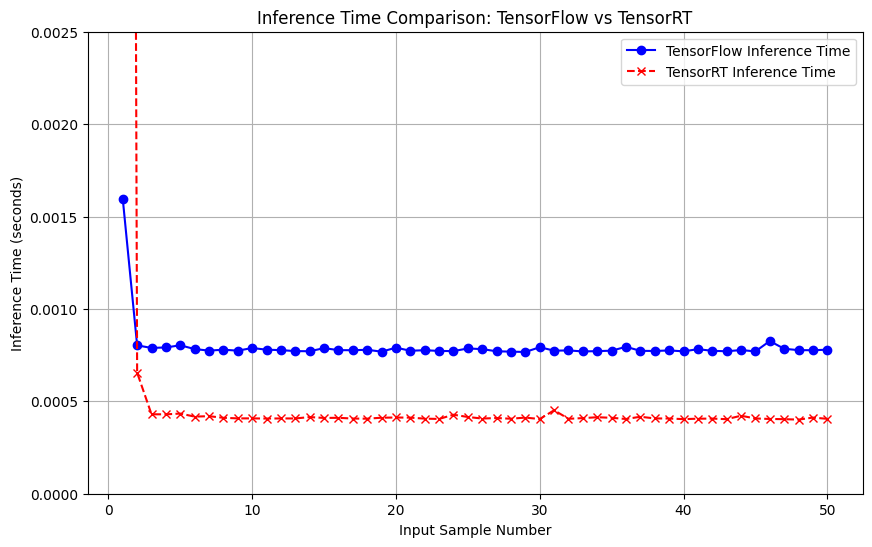

In [4]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.python.compiler.tensorrt import trt_convert as trt

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def measure_inference_times(model, input_data, num_samples=50):
    inference_times = []
    
    # Measure inference time for each sample
    for i in range(num_samples):
        start_time = time.time()
        # Use the model directly for inference
        model(input_data[i % len(input_data)][np.newaxis, ...])  # Call the model directly
        end_time = time.time()
        
        # Calculate inference time for the current sample
        inference_times.append(end_time - start_time)
    
    return inference_times

def convert_to_tensorrt(model):
    # Save the TensorFlow model
    tf.saved_model.save(model, 'saved_model')

    # Use TensorRT to optimize the model
    converter = trt.TrtGraphConverterV2(input_saved_model_dir='saved_model')
    converter.convert()
    converter.save('tensorrt_model')
    
    # Load the TensorRT model
    return tf.saved_model.load('tensorrt_model')

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to [0, 1]
x_test = x_test.astype(np.float32) / 255.0

# Ensure test_data has at least 50 samples
if x_test.shape[0] < 50:
    raise ValueError("Test data must contain at least 50 samples.")

# Create and train the model
model = create_model()
model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=2)

# Measure inference times for the first 50 inputs using TensorFlow
tf_inference_times = measure_inference_times(model, x_test[:50])

# Convert the model to TensorRT
tensorrt_model = convert_to_tensorrt(model)

# Measure inference times for the first 50 inputs using TensorRT
tensorrt_inference_times = measure_inference_times(tensorrt_model, x_test[:50])

# Plot the inference times for comparison
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), tf_inference_times, marker='o', linestyle='-', color='b', label='TensorFlow Inference Time')
plt.plot(range(1, 51), tensorrt_inference_times, marker='x', linestyle='--', color='r', label='TensorRT Inference Time')
plt.xlabel("Input Sample Number")
plt.ylabel("Inference Time (seconds)")
plt.title("Inference Time Comparison: TensorFlow vs TensorRT")
plt.ylim(0,0.0025)
plt.legend()
plt.grid(True)
plt.show()
